# Basic demonstration of creating and using masks for bright sources
### Author: Adam D. Myers, University of Wyoming

## Getting Started

Everything should work fine using a DESI kernel loaded from NERSC's jupyter-dev server. See the instuctions under *Getting Started* at:

https://github.com/desihub/tutorials/blob/master/Intro_to_DESI_spectra.ipynb

If you're running locally on your own machine, you may also need to set up your own development kernel as described here:

https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC

under *defining your own kernel*.

## Preliminaries

Now, retrieve a sample of the sweeps files, say, everything in DR5 that starts sweep-150. I'll assume you put this in your $CSCRATCH directory at NERSC, as follows:

```
mkdir $CSCRATCH/sweep150
cp /global/project/projectdirs/cosmo/data/legacysurvey/dr5/sweep/5.0/sweep-150* $CSCRATCH/sweep150
```

## Creating a mask based on bright sources from a sweep-like file or files at the command line

To create a bright source mask by scraping bright sources (of all types) from the sweeps:

```
make_bright_mask $CSCRATCH/sweep150 $CSCRATCH/sourcemask150.fits 
```

this mask will use default settings and create masks for everything that is brighter than 10th magnitude in each of the *g*, *r* and *z* bands. This took just under 1.5 minutes, for me, on edison, and returned the following informative message:

```
INFO:make_bright_mask:48:<module>: wrote a file of 1292 masks to $CSCRATCH/sourcemask150.fits
```

You can also customize the limiting magnitude of source to be masked, e.g.:

```
make_bright_mask $CSCRATCH/sweep150 --bands GZ --maglim 9,10 $CSCRATCH/blat.fits
```

will mask any source that is brighter than *g* < 9 or *z* < 10.

This took about 1.5 minutes for me on edison and returned the following message:

```
INFO:make_bright_mask:48:<module>: wrote a file of 1164 masks to $CSCRATCH/blat.fits
```

## Plotting masks

Let's examine the mask and plot it. Note that ```NEAR_RADIUS``` is a warning that you're near a mask (which could be useful for large-scale structure analyses) whereas ```IN_RADIUS``` is the radius to which DESI will certainly *not* place any fibers (for fear of saturating adjacent sources).


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import fitsio
from desitarget import desi_mask, brightmask

You may have to set up your ```$CSCRATCH``` environment variable so that ```Python``` can find it, e.g.:

In [2]:
os.environ["CSCRATCH"] = '/global/cscratch1/sd/adamyers'

In [3]:
sourcemask = fitsio.read("$CSCRATCH/sourcemask150.fits")

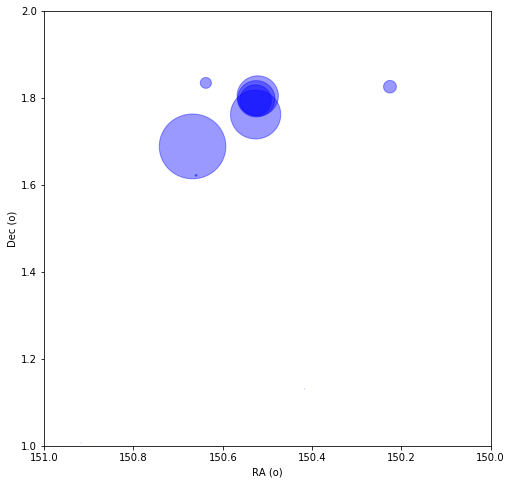

In [4]:
brightmask.plot_mask(sourcemask,limits=[151,150,1,2])

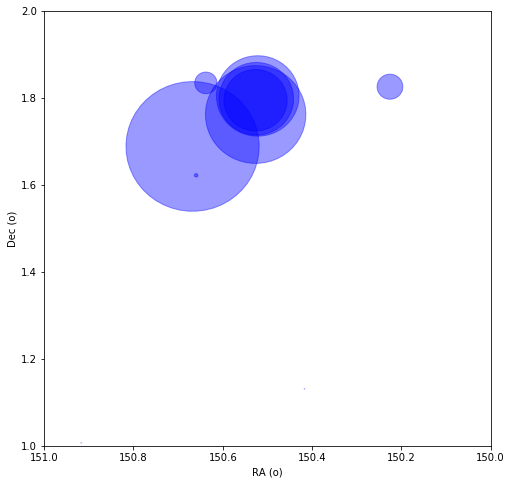

In [5]:
brightmask.plot_mask(sourcemask,limits=[151,150,1,2],radius="NEAR_RADIUS")

These are some circular regions that could be masked, but let's check the capability also for elliptical regions:

In [6]:
from desitarget.brightmask import _rexlike
from desitarget.cuts import _psflike
rex_or_psf = _rexlike(sourcemask["TYPE"]) |  _psflike(sourcemask["TYPE"])
wcircle = np.where(rex_or_psf)
wellipse = np.where(~rex_or_psf)
sourcemask[wcircle][20:25]

array([ (159.35170256913204, -6.704741203413147, 21991458085016789, 0.6521973609924316, 1.3043947219848633, 0.0, 0.0, b'REX '),
       (153.96544089693788, -5.909069051811359, 21991476019858620, 0.6479077339172363, 1.2958154678344727, 0.0, 0.0, b'REX '),
       (158.85543248566393, -5.361831710357371, 21991494147637304, 0.8473171591758728, 1.6946343183517456, 0.0, 0.0, b'REX '),
       (150.26427813132204, -6.853210395538962, 21991457934016880, 0.5829144716262817, 1.1658289432525635, 0.0, 0.0, b'REX '),
       (150.2125966126422, -6.704543907470019, 21991457934020711, 0.6648531556129456, 1.3297063112258911, 0.0, 0.0, b'REX ')], 
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('TARGETID', '>i8'), ('IN_RADIUS', '>f4'), ('NEAR_RADIUS', '>f4'), ('E1', '>f4'), ('E2', '>f4'), ('TYPE', 'S4')])

In [7]:
sourcemask[wellipse][20:25]

array([ (153.32494601815782, 15.344005999895943, 21991985220946532, 4.119004249572754, 8.238008499145508, 0.04788007587194443, -0.0831557959318161, b'COMP'),
       (150.336328834415, 15.670273316474681, 21991996834971936, 5.884766578674316, 11.769533157348633, 0.02479759231209755, -0.05855797603726387, b'COMP'),
       (152.0618963009859, 17.357379392142807, 21992031651892015, 12.720791816711426, 25.44158363342285, -0.0435304157435894, -0.0217534638941288, b'EXP '),
       (155.87751319196906, 19.86516531128496, 21992089097078985, 145.9065399169922, 291.8130798339844, 0.23292440176010132, -0.23275092244148254, b'COMP'),
       (153.82259519591108, 17.017784819343035, 21992025897305953, 3.3296713829040527, 6.6593427658081055, 0.05828319117426872, -0.007378529291599989, b'COMP')], 
      dtype=[('RA', '>f8'), ('DEC', '>f8'), ('TARGETID', '>i8'), ('IN_RADIUS', '>f4'), ('NEAR_RADIUS', '>f4'), ('E1', '>f4'), ('E2', '>f4'), ('TYPE', 'S4')])

Note that the ellipticity components, here, which are defined at the bottom of the page at, e.g., http://legacysurvey.org/dr5/catalogs/ are 0.0 for circular masks. 

Let's plot a region that has a mix of circular and elliptical masks:

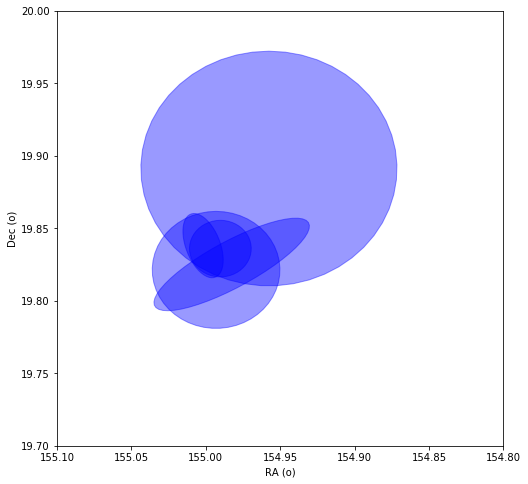

In [8]:
brightmask.plot_mask(sourcemask,limits=[155.1,154.8,19.7,20.0],radius="NEAR_RADIUS")

## Creating a file of targets and masking at the command line

Now let's compile a file of targets from the same set of sweeps. Again, I'll dump the targets file in your $CSCRATCH 
directory. This took just under 4 minutes, for me:

```
select_targets $CSCRATCH/sweep150 $CSCRATCH/targs150.fits
```

and informed me that:

```
INFO:select_targets:73:<module>: 1741104 targets written to /global/cscratch1/sd/adamyers/targs150.fits
```

Note that at NERSC, the whole masking procedure can be applied to the targets in one line of code via, e.g.:

```
select_targets $CSCRATCH/sweep150 $CSCRATCH/targsblat150.fits --mask $CSCRATCH/sourcemask150.fits
```

## Generating ```BADSKY``` ("SAFE") locations

First, let's generate ```BADSKY``` ("SAFE") locations around the periphery of each mask and plot them against the backdrop of the mask. Note that ```drstring```, if set, is used to assign the Data Release (DR) bit to ```BADSKY``` targets and to assign ```BADSKY``` targets an ```OBJID``` that is higher than any target in a given brick of that DR. (That's the part that requires a DR ```survey-brick``` file, though).

In [9]:
targs = fitsio.read("$CSCRATCH/targs150.fits")
print(len(targs))
print(len(np.where( (targs["DESI_TARGET"] & desi_mask.BADSKY) != 0 )[0]))

1741104
0


In [10]:
targs = brightmask.append_safe_targets(targs,sourcemask)
print(len(targs))
print(len(np.where( (targs["DESI_TARGET"] & desi_mask.BADSKY) != 0 )[0]))

1748080
6976


In [11]:
w = np.where( (targs["DESI_TARGET"] & desi_mask.BADSKY) != 0 )
badskies= targs[w]

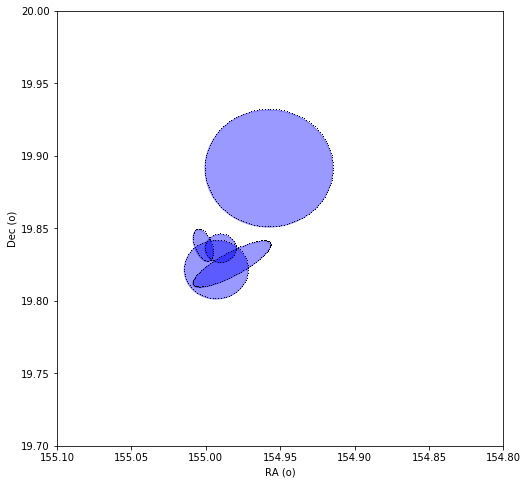

In [12]:
brightmask.plot_mask(sourcemask,show=False)
plt.axis([155.1,154.8,19.7,20.0])
plt.plot(badskies["RA"],badskies["DEC"],'k,')
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
plt.show()

## Masking targets

Our targets will already have ```DESI_TARGET``` bits set (indicating whether something is an LRG, ELG, QSO etc.) but we can update those bits to indicate which targets are in or are not in a mask. The ```IN_BRIGHT_OBJECT``` bit in ```DESI_TARGET``` indicates whether something is in a mask.

In [13]:
desi_mask

desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200, 'OBS': 1, 'UNOBS': 3200, 'DONE': 2}}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000, 'OBS': 1, 'UNOBS': 3000, 'DONE': 2}}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'DONOTOBSERVE': 0, 'MORE_ZWARN': 3400, 'MORE_ZGOOD': 3500, 'OBS': 1, 'UNOBS': 3400, 'DONE': 2}}]
  - [LRG_1PASS,        3, "LRG observed in 1st pass", {'obsconditions': 'DARK', 'priorities': {'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200, 'OBS': 1, 'UNOBS': 3200, 'DONE': 2}}]
  - [LRG_2PASS,        4, "LRG observed in 2nd pass", {'obsconditions': 'DARK', 'priorities': {'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200, 'OBS': 1, 'UNOBS': 3200, 'DONE': 2}}]
  - [LRG_NORTH,        8, "LRG from Bok/Mosaic data", {'obsconditions': 'DARK', 'priori

In [14]:
dt = brightmask.set_target_bits(targs,sourcemask)
inmask = np.where( (dt & desi_mask.IN_BRIGHT_OBJECT) != 0) 
masked = targs[inmask]
notinmask = np.where( (dt & desi_mask.IN_BRIGHT_OBJECT) == 0) 
unmasked = targs[notinmask]

INFO:brightmask.py:678:is_in_bright_mask: Testing 32553 total targets against 39 total elliptical masks...t=13.8s
INFO:brightmask.py:703:is_in_bright_mask: Done with elliptical masking...t=13.939393s


Let's plot which objects are in masks and which are not, against the backdrop of the mask (in a small region of the sky):

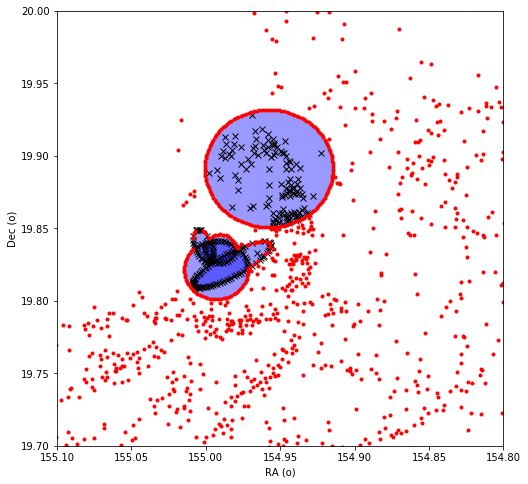

In [15]:
brightmask.plot_mask(sourcemask,show=False)
plt.axis([155.1,154.8,19.7,20.0])
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
plt.plot(masked["RA"],masked["DEC"],'kx')
plt.plot(unmasked["RA"],unmasked["DEC"],'r.')
plt.show()

Note that the ```BADSKY``` locations are just outside the perimeter of the masks, and are quite obvious in the plot.

## Masking points from a random catalog

The ```brightmask.set_target_bits()``` function wraps the main masking code in ```brightmask```, called ```is_in_bright_mask()```. The ```is_in_bright_mask()``` function can be used to compare coordinate locations to a mask and return which objects are in the mask (within the ```IN_RADIUS``` of the mask) and which objects are close to the mask (within the ```NEAR_RADIUS``` of the mask).

Let's create a random catalog over the small area of sky that we've been considering (154.8<sup>o</sup> < RA < 155.1<sup>o</sup>) and (19.7<sup>o</sup> < Dec < 20.0<sup>o</sup>):

In [16]:
from numpy.random import random
Nran = 100000
rancat = np.zeros(Nran, dtype=[('RA', '>f8'), ('DEC', '>f8')])
rancat["RA"] = 154.8+0.3*(random(Nran))
rancat["DEC"] = np.degrees(np.arcsin(np.sin(np.radians(20))-random(Nran)*0.05))

Now let's mask that random catalog:

In [17]:
inmask, nearmask = brightmask.is_in_bright_mask(rancat,sourcemask)
masked = rancat[np.where(inmask)]
notmasked = rancat[np.where(~inmask)]
near = rancat[np.where(nearmask)]
notnear = rancat[np.where(~nearmask)]

INFO:brightmask.py:678:is_in_bright_mask: Testing 13215 total targets against 2 total elliptical masks...t=0.6s
INFO:brightmask.py:703:is_in_bright_mask: Done with elliptical masking...t=0.604618s


and plot the random points that *are* and *are not* in the mask, both for the ```IN_RADIUS``` and the ```NEAR_RADIUS```:

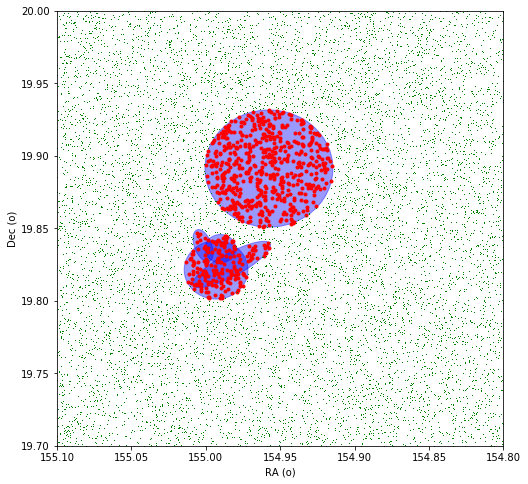

In [18]:
brightmask.plot_mask(sourcemask,show=False)
plt.axis([155.1,154.8,19.7,20.0])
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
plt.plot(masked["RA"],masked["DEC"],'r.')
plt.plot(notmasked["RA"],notmasked["DEC"],'g,')
plt.show()

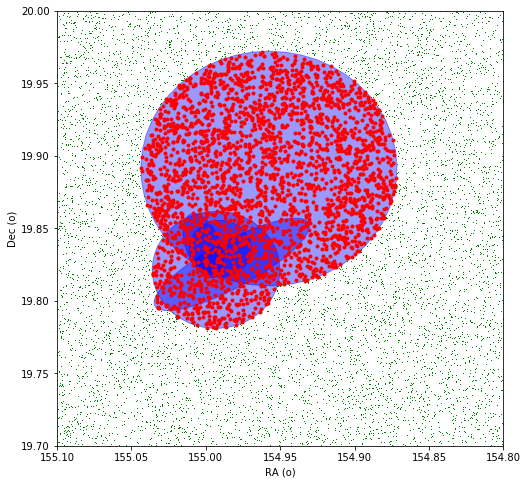

In [19]:
brightmask.plot_mask(sourcemask,show=False,radius="NEAR_RADIUS")
plt.axis([155.1,154.8,19.7,20.0])
plt.xlabel('RA (o)')
plt.ylabel('Dec (o)')
plt.plot(near["RA"],near["DEC"],'r.')
plt.plot(notnear["RA"],notnear["DEC"],'g,')
plt.show()